In [6]:
import tweepy1

In [7]:
# %load utils.py
# CrisisLex
# Author: Alexandra Olteanu
# Check LICENSE for details about copyright.

import json

#receives a string in json format
#returns the textual content of a tweet
def extract_tweet_from_json(data):
    try:
        json_tweet = json.loads(data.strip())
    except:
        exit("Not able to load json data")
    if 'text' in json_tweet:
        return json_tweet['text'].replace('\n','')
    else:
        return None

# reads the terms to be tracked from a file
# expects one term per line
def get_query_terms(input_filename):
    query_terms = []
    for line in input_filename:
        query_terms.append(line.strip())
    return query_terms

In [8]:
# %load config.py
#Sets Twitter API access

#Please give the keys as 'strings'
CONSUMER_KEY = 'm4pfoQYtQOCahpKEY55dlogg7' # API key
CONSUMER_SECRET = 'TdU3rKhwfspQYrSA0GsPW7IooRkbw9opfZ82KZmADsGvnAUL01' # API secret
ACCESS_KEY = '798171014693879808-9I6Ms2tOWxLmXlwVbNHmEoYQJxO97rB' # Access token
ACCESS_SECRET= '3vEM0E6i6OfmNE95ng8VcK6dHtKS6qByQoD7mZtp7qqvb' # Access token secret

In [10]:
import sys
import os

import tweepy1 as t
from tweepy1.parsers import ModelParser
from tweepy1 import StreamListener
from tweepy1 import Stream


import utils
import config as c

class PrintListener(StreamListener):
    output = None
    def on_data(self, data):
        if self.output is None:
            print data
            return True
        else:
            print>>self.output, data.strip()
            return True

    def on_error(self, status):
        if status == 420:
            print status, "Twitter API Error: Enhance your calm -- You are being rate limited"
        elif status == 401:
            print status, "Twitter API Error: Unauthorized -- Authentication credentials were missing or incorrect. Please double check config.py"
        else:
            print status
        
    def set_output(self, output_json):
        self.output = output_json

#authenticate
auth = t.OAuthHandler(c.CONSUMER_KEY, c.CONSUMER_SECRET)
auth.set_access_token(c.ACCESS_KEY, c.ACCESS_SECRET)
api = t.API(auth_handler=auth, parser = ModelParser())      
        
print "Configuring query settings ...."  
    
filename = 'data/test3.txt'
lexicon = 'CrisisLexRec.txt'
pl = PrintListener()
pl.set_output(open(filename,"w"))

try:
        to_track = utils.get_query_terms(open(lexicon,"r"))
except Exception as e:
        print "The file path is seems to be wrong. Check the error below or run the script with -h. Please revise and restart the script"
        print e
        exit(0)
        
#start tracking crisis-relevant tweets
stream = Stream(auth, pl)
try:
    print "Collecting tweets ...."
    stream.filter(track=to_track[0:400],locations=[-6.38,49.87,1.77,55.81],languages=["en"])
except Exception as e:
    print "The script have crashed with the following error: "
    print e
    print "\n Please check if your Twitter API keys are correct"        
        

Configuring query settings ....


KeyboardInterrupt: 

In [1]:
# %load adaptive_collect.py
# CrisisLex
# Author: Alexandra Olteanu
# Check LICENSE for details about copyright.

import sys
import utils
import os

#handling time
import datetime

#tweepy1
import tweepy1 as t
from tweepy1.parsers import ModelParser
from tweepy1 import StreamListener
from tweepy1 import Stream


# authentication parameters
import config as c

#nlp processing
import nltk
from nltk.corpus import stopwords

#processes the tweet and updates hashtag_fd
#specifically, if the hashtag was already encountered it adds it to the freq dict,
# otherwise it increases the hashtag counter
def update_hashtags_stats(hashtags_fd, json_tweet):
    tweet = utils.extract_tweet_from_json(json_tweet)
    tweet_terms = []
    if tweet is None or '#' not in tweet:
        return False
    tokenizer = nltk.RegexpTokenizer('\#?[\w\d]+')
    doc = tokenizer.tokenize(tweet)
    for w_raw in doc:
        if '#' not in w_raw:
            continue
        w = (w_raw.strip('\"\'.,;?!:)(@/*&')).lower()
        tweet_terms.append(w)
        hashtags_fd.inc(w)
    return True


#processes the tweet and updates terms_fd based on the tweet terms
#specifically, if the term was already encountered it adds it to the freq dict,
# otherwise it increases the term counter
def update_terms_stats(terms_fd, json_tweet, lex):
    tweet = utils.extract_tweet_from_json(json_tweet)
    tweet_terms = []
    if tweet is None:
        return False
    tokenizer = nltk.RegexpTokenizer('\#?[\w\d]+')
    doc = tokenizer.tokenize(tweet)
    for w_raw in doc:
        w = w_raw.strip('\"\'.,;?!:)(@/*&')
        if not (w.strip('#')).isalpha():
            w_aux = ''
            #ignore non-ascii characters
            for s in w:
                if ord(s) < 128:
                    w_aux += s
                else:
                    break
            w = w_aux
        w = w.lower()
        if (w not in stopwords.words('english') and w not in set(['rt','http','amp'])) and len(w) in range(3, 16):
            if w in lex:
                continue
            tweet_terms.append(w)
            terms_fd.inc(w)
    bigrams = nltk.bigrams(tweet_terms)
    for b in bigrams:
        if b[1]+" "+b[0] in lex or b[0]+" "+b[1] in lex:
            continue
        if b[1]+" "+b[0] in terms_fd:
            terms_fd.inc(b[1]+" "+b[0])
        else:
            terms_fd.inc(b[0]+" "+b[1])
    return True


class AdaptiveListener(StreamListener):
    output = None
    adaptive = False
    start_time = None
    end_time = None
    terms = None
    terms_fd = None
    terms_no = 0
    lex_set = None
    use_hashtags = True

    def on_data(self, data):
        #prints to screen the filtered tweets
        if self.output is None:
            print data
            return True

        #prints to file the filtered tweets without any other actions
        print>>self.output, data.strip()
        if self.adaptive is False:
            return True

        #collects statistics from the tweets collected in the first hours and prints the tweets to file
        if self.adaptive:
            if datetime.datetime.now()>self.end_time:
                self.terms = self.terms_fd.keys()[:self.terms_no]
                print "Adding to the query the following terms:"
                print self.terms
                return False

            if self.use_hashtags:
                update_hashtags_stats(self.terms_fd,data)
            else:
                update_terms_stats(self.terms_fd,data,self.lex_set)
            return True

    def on_error(self, status):
        if status == 420:
            print status, "Twitter API Error: Enhance your calm -- You are being rate limited"
        elif status == 401:
            print status, "Twitter API Error: Unauthorized -- Authentication credentials were missing or incorrect. Please double check config.py"
        else:
            print status

    def set_output(self, output_json):
        self.output = output_json

    def set_adaptive(self, lex, learning_time=3, use_hashtags=True, new_terms_no=10):
        self.adaptive = True
        self.lex_set = set(lex)
        self.terms_no = new_terms_no
        self.use_hashtags = use_hashtags

        self.start_time = datetime.datetime.now()
        self.end_time = self.start_time + datetime.timedelta(hours=learning_time)
        print "Learning interval between %s to %s"%(self.start_time,self.end_time)

        self.terms_fd = nltk.FreqDist()
        self.terms = []

if __name__ == "__main__":

    filename = 'data/test3.txt'
    lexicon = 'CrisisLexRec.txt'
    prf_time = 1
    adaptive = False
    hashtags = 1
    new_terms_no = 5

    #authenticate
    auth = t.OAuthHandler(c.CONSUMER_KEY, c.CONSUMER_SECRET)
    auth.set_access_token(c.ACCESS_KEY, c.ACCESS_SECRET)
    api = t.API(auth_handler=auth, parser=ModelParser())

    #set up the stream listener
    pl = AdaptiveListener()
    pl.set_output(open(filename,"w"))

    # get lexicon terms
    try:
        to_track = utils.get_query_terms(open(lexicon,"r"))
    except Exception as e:
        print "The file path is seems to be wrong. Check the error below or run the script with -h. Please revise and restart the script"
        print e
        exit(0)


    #set the learning time
    if adaptive:
        pl.set_adaptive(to_track, prf_time, (hashtags == 1), new_terms_no)

    #start tracking crisis-relevant tweets
    stream = Stream(auth, pl)
    stream.filter(track=to_track[0:400],locations=[-6.38,49.87,1.77,55.81],languages=["en"])

    print "New query..."
    #add new terms to be tracked and restart the crawling.
    if pl.adaptive:
        assert pl.terms
        to_track[0:0] = pl.terms

    pl.adaptive = False
    stream.filter(track=to_track[0:400],locations=[-6.38,49.87,1.77,55.81],languages=["en"])

KeyboardInterrupt: 

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt

tweets_data_path = './data/test3.txt'
tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
        
print len(tweets_data) 

tweets = pd.DataFrame()
tweets['text'] = map(lambda tweet: tweet.get('text', None),tweets_data)
tweets['lang'] = map(lambda tweet: tweet.get('lang', None),tweets_data)
tweets['country'] = map(lambda tweet: tweet.get('place').get('country', None) if tweet.get('place') != None else None, tweets_data)

1314


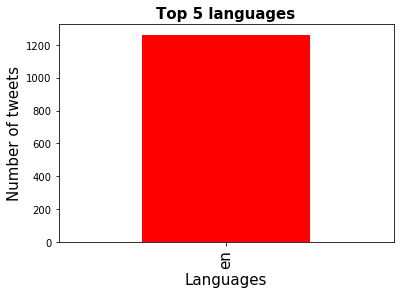

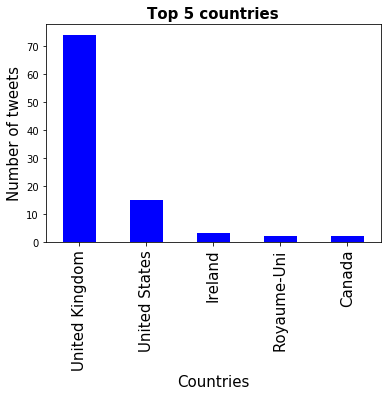

In [26]:
%matplotlib inline
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

In [2]:
import csv
with open('2012_Sandy_Hurricane-ontopic_offtopic.csv','rU') as fin, open ('outfile2','w') as fout:
    writer = csv.writer(fout, delimiter=',')
    for row in csv.reader(fin, delimiter=','):
        if row[2] == 'on-topic':
             writer.writerow(row)

In [3]:
with open("outfile2", "rb") as source:
    lines = [line for line in source]
import random
random_choice = random.sample(lines, 3870)
with open("outfile3", "wb") as sink:
    sink.write("".join(random_choice))

In [2]:
import json
with open('nepal_pos.json') as tweet_data:
    json_data = json.load(tweet_data)

ValueError: Extra data: line 2 column 1 - line 4688 column 1 (char 4898 - 19821687)

In [23]:
import json
from datetime import datetime
import pandas as pd
import time
import string

tweets_data_path = 'nepal_neg.json'
tweets_data = []
tweets_file = open(tweets_data_path, "r")
fout = open('nepal_neg_txt.csv','w+')
for line in tweets_file:
    try:
        tweet = json.loads(line)
        date = tweet['created_at']
        id = tweet['id']
        if 'retweeted_status' in tweet:
            text = tweet['retweeted_status']['text']
        else:
            text = tweet['text']
        #print(text)    
        try:
            c = time.strptime(date.replace("+0000",''), '%a %b %d %H:%M:%S %Y')
        except: 
            print "pb with tweet_gmttime", tweet_gmttime, line
            pass
        tweet_unixtime = int(time.mktime(c))
        #fout.write(str(text) + "\t" + str(id) + "\n")
        fout.write(str([text]) + "\n")
        #print(tweet_unixtime)
        #tweets_data.append(tweet)
    except:
        continue

tweets_file.close()        
fout.close()         
#tweets = pd.DataFrame()
#tweets['text'] = map(lambda tweet: tweet.get('text', None),tweets_data)
#tweets_by_text = tweets['text'].value_counts()
#f1=open('output5.txt', 'w+')
#print >> f1,tweets_by_text